# Example No 4 : CNN model by Keras for Cats & Dogs Classification

# Table of Content 
- [ 1 - Introduction ](#intro)
    - [ 1.1 What is the new we will learn in this example ? ](#example_imp)
    - [ 1.2 The source of the data ](#data_source)
    
    - [ 1.3 Load the required libraries ](#import)
    
- [ 2 - Data preparation ](#preparation)
    - [ 2.1 Define some constants ](#constants)
    - [ 2.2 Prepare Training Data](#prepare_training)
    - [ 2.3 Split data to training and validating](#split_data)

    - [ 2.4 Data Augmentation](#augmentation)

- [ 3- Build CNN model ](#CNN_model)
    - [ 3.1 Define our CNN model ](#define_model)
    - [ 3.2 Early Stopping ](#early_stopping)

    - [ 3.3 Learning Rate Reduction ](#rate_reduction)


- [ 4- Train (Fit) & Evaluate the model](#train_model)
    - [ 4.1 The history of model learning on training data ](#model_history)

    - [ 4.2 Evaluate our CNN Model](#evaluate_model)

- [ 5 - Testing our model ](#testing_model)
    - [ 5.1 Prepare Testing Data ](#prepare_test)

    - [ 5.2 Create Testing Generator](#test_generator)

- [6- Prediction ](#prediction)
    - [ 6.1 Make Predictions using our trained model ](#make_prediction)
    - [ 6.2 Visualize the result  ](#visualize_results)

    - [ 6.3 Visualize predicted result with images](#visualize_prediction)

-  [ Further TensorFlow (Keras) Applications for CNN ](#other_apps)

-  [ Key Resources Utilized in Crafting This Notebook](#resources)



<a name="intro"></a>
## 1 - Introduction

<a name="example_imp"></a>
### 1.1 What is the new we will learn in this example ?
We will build a CNN using Keras for the purpose of classifying a more challenging image classification tasks to classify the cats and dogs.

<a name="data_source"></a>
### 1.2 The source of the data 
The original code of this example and the data from Kaggle and you can download; [Keras CNN Dog or Cat Classification](https://www.kaggle.com/uysimty/keras-cnn-dog-or-cat-classification). 

<a name="import"></a>
### 1.3 Load the required libraries

In [31]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras.utils import load_img
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

<a name="preparation"></a>
## 2 - Data preparation 

In [34]:
print(os.listdir("Cats_Dogs"))

['test', 'train']


<a name="constants"></a>
### 2.1 Define some constants

In [35]:
FAST_RUN = True
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [36]:
if FAST_RUN :
    print ("Yes")

Yes


<a name="prepare_training"></a>
### 2.2 Prepare Training Data

In [37]:
filenames = os.listdir("Cats_Dogs/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [38]:
df.head()

filename  category
0   dog.8011.jpg         1
1   cat.5077.jpg         0
2   dog.7322.jpg         1
3   cat.2718.jpg         0
4  cat.10151.jpg         0

#### A) Visualize training total count  

<Axes: xlabel='category'>

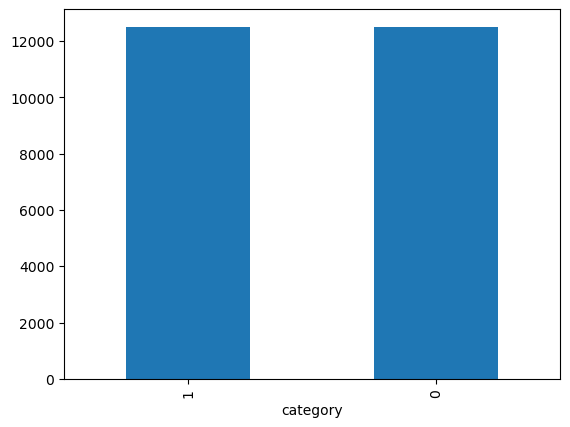

In [39]:
df['category'].value_counts().plot.bar()

> Clear that : from our data we have 12500 cats and 12500 dogs

#### B) Display sample image

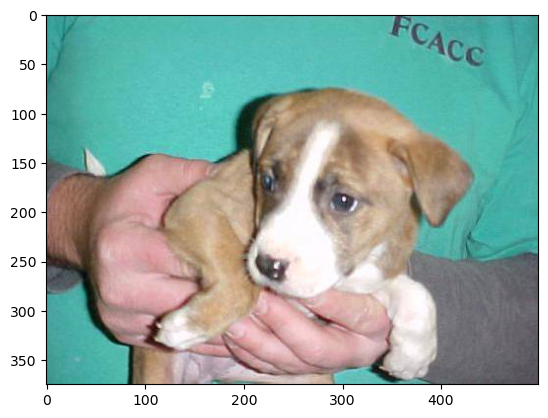

In [40]:
sample = random.choice(filenames)
image = load_img("Cats_Dogs/train/"+sample)
plt.imshow(image)

<a name="split_data"></a>
### 2.3 Split data to training and validating  

* Because we will use image genaretor `with class_mode="categorical"`. We need to convert column category into string. 
* Then imagenerator will convert it one-hot encoding which is good for our classification. 

> So we will convert 1 to dog and 0 to cat

In [41]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [42]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [43]:
train_df['category'].value_counts().plot.bar()

<Axes: xlabel='category'>

<Axes: xlabel='category'>

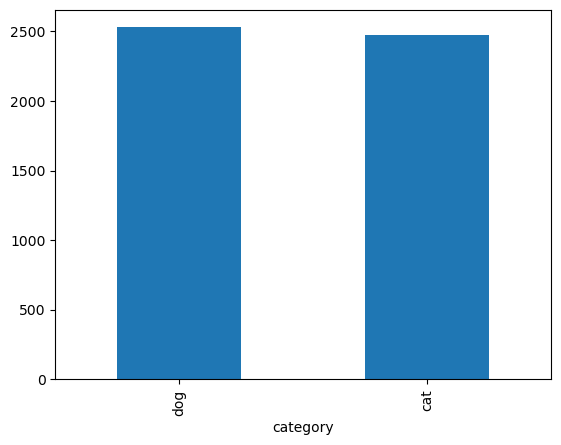

In [44]:
validate_df['category'].value_counts().plot.bar()

In [45]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

<a name="augmentation"></a>
### 2.4 Data Augmentation

#### A) Training Generator

In [46]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "Cats_Dogs/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


#### B) Validation Generator

In [47]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "Cats_Dogs/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


#### C) Display some examples to show how generator work

In [48]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "Cats_Dogs/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


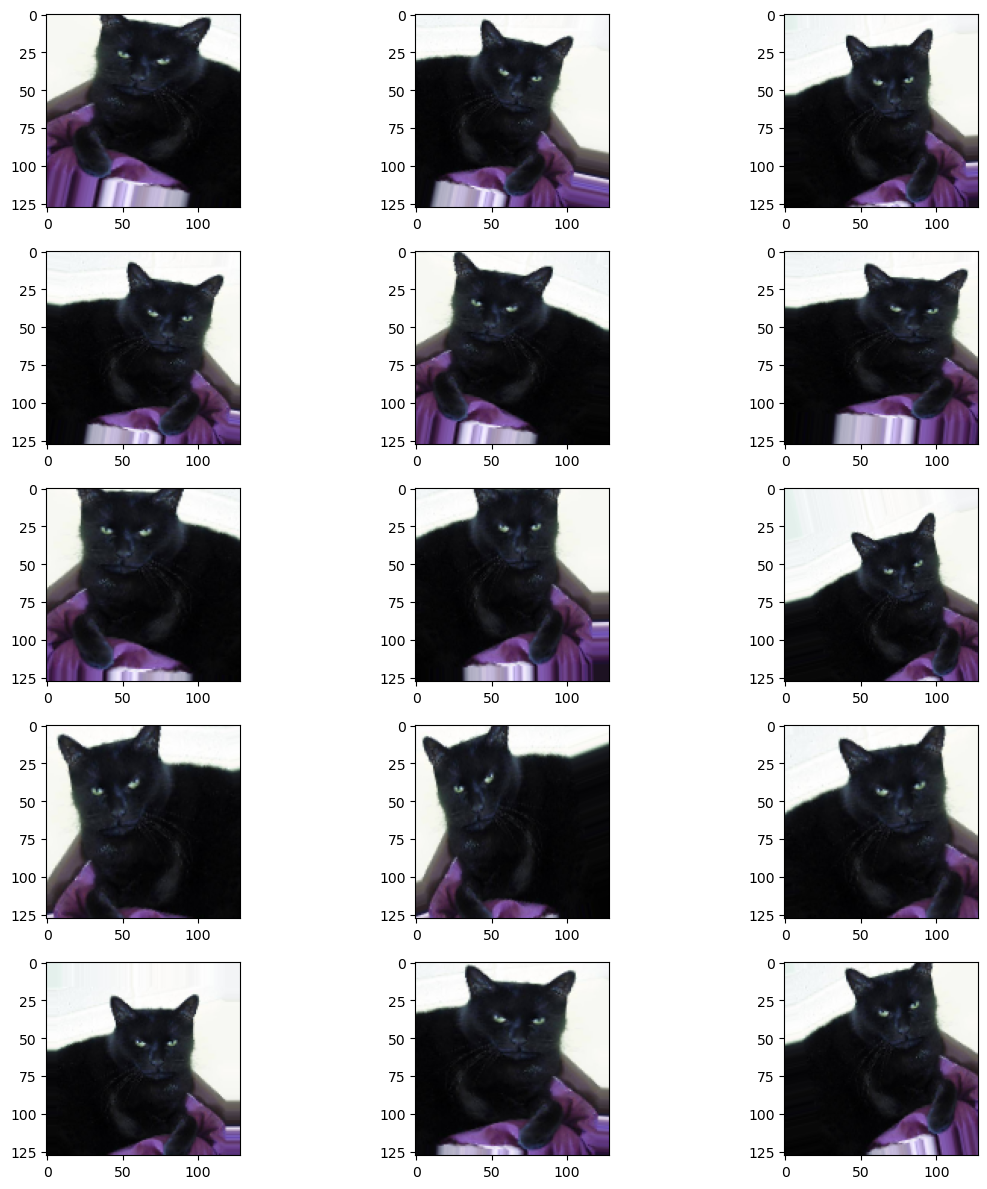

In [49]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

> Let's build our model

<a name="CNN_model"></a>
## 3- Build CNN model 


<img src="https://i.imgur.com/ebkMGGu.jpg" width="100%"/>

<a name="define_model"></a>
### 3.1 Define our CNN model

* **Input Layer**: It represent input image data. It will reshape image into single diminsion array. Example your image is 64x64 = 4096, it will convert to (4096,1) array.
* **Conv Layer**: This layer will extract features from image.
* **Pooling Layer**: This layerreduce the spatial volume of input image after convolution.
* **Fully Connected Layer**: It connect the network from a layer to another layer
* **Output Layer**: It is the predicted values layer. 

In [18]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

> To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

<a name="early_stopping"></a>
### 3.2 Early Stopping 

In [19]:
earlystop = EarlyStopping(patience=10)

<a name="rate_reduction"></a>
###  3.3 **Learning Rate Reduction**

* We will reduce the learning rate when the accuracy not increase for 2 steps

In [20]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [21]:
callbacks = [earlystop, learning_rate_reduction]

<a name="train_model"></a>
## 4- Train (Fit) & Evaluate the model

In [22]:
epochs=10 if FAST_RUN else 50
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/10
1333/1333 [==============================] - 156s 117ms/step - loss: 0.7506 - accuracy: 0.6320 - val_loss: 0.8058 - val_accuracy: 0.6026 - lr: 0.0010
Epoch 2/10
1333/1333 [==============================] - 157s 118ms/step - loss: 0.5607 - accuracy: 0.7157 - val_loss: 0.5671 - val_accuracy: 0.7275 - lr: 0.0010
Epoch 3/10
1333/1333 [==============================] - 258s 194ms/step - loss: 0.5043 - accuracy: 0.7600 - val_loss: 0.4170 - val_accuracy: 0.8118 - lr: 0.0010
Epoch 4/10
1333/1333 [==============================] - 210s 157ms/step - loss: 0.4660 - accuracy: 0.7825 - val_loss: 0.7088 - val_accuracy: 0.7447 - lr: 0.0010
Epoch 5/10
1333/1333 [==============================] - 153s 115ms/step - loss: 0.4446 - accuracy: 0.7955 - val_loss: 0.5617 - val_accuracy: 0.7107 - lr: 0.0010
Epoch 6/10
1333/1333 [==============================] - 148s 111ms/step - loss: 0.4175 - accuracy: 0.8115 - val_loss: 0.3222 - val_accuracy: 0.8683 - lr: 0.0010
Epoch 7/10
1333/1333 [============

<a name="model_history"></a>
### 4.1 The history of model learning on training data 
> The Accuracy & Loss Vs Epochs for Training and Validation datasets  

In [50]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

<a name="evaluate_model"></a>
### 4.2 Evaluate our CNN Model

* Let's assessing its performance on a separate dataset, typically a validation set.

In [57]:
training_loss, training_acc = model.evaluate(train_generator, verbose=0)
print('The accuracy of our model on Training dataset : %.2f' % (training_acc*100))
print('The loss of our model on Training dataset : %.2f' % (training_loss*100))

The accuracy of our model on Training dataset : 85.10
The loss of our model on Training dataset : 34.14


In [59]:
cross_val_loss, cross_val_acc = model.evaluate(validation_generator, verbose=0)
print('The accuracy of our model on Test dataset : %.2f' % (cross_val_acc*100))
print('The loss of our model on Test dataset : %.2f' % (cross_val_loss*100))

The accuracy of our model on Test dataset : 87.70
The loss of our model on Test dataset : 29.94


<a name="testing_model"></a>
## 5 - Testing our model 

<a name="prepare_test"></a>
### 5.1 Prepare Testing Data

In [51]:
test_filenames = os.listdir("Cats_Dogs/test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

<a name="test_generator"></a>
### 5.2 Create Testing Generator

In [52]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "Cats_Dogs/test/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


<a name="prediction"></a>
## 6- Prediction

<a name="make_prediction"></a>
### 6.1 Make Predictions using our trained model

In [53]:
predictions = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

834/834 [==============================] - 26s 31ms/step


* For categoral classication the prediction will come with probability of each category. 
* So we will pick the category that have the highest probability with numpy average max

In [54]:
test_df['category'] = np.argmax(predictions, axis=-1)

We will convert the predict category back into our generator classes by using `train_generator.class_indices`. It is the classes that image generator map while converting data into computer vision

In [30]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

From our prepare data part. We map data with `{1: 'dog', 0: 'cat'}`. Now we will map the result back to dog is 1 and cat is 0

In [71]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

<a name="visualize_results"></a>
### 6.2 Visualize the result 

In [72]:
test_df['category'].value_counts().plot.bar();

<Axes: xlabel='category'>

<a name="visualize_prediction"></a>
### 6.3 Visualize predicted result with images

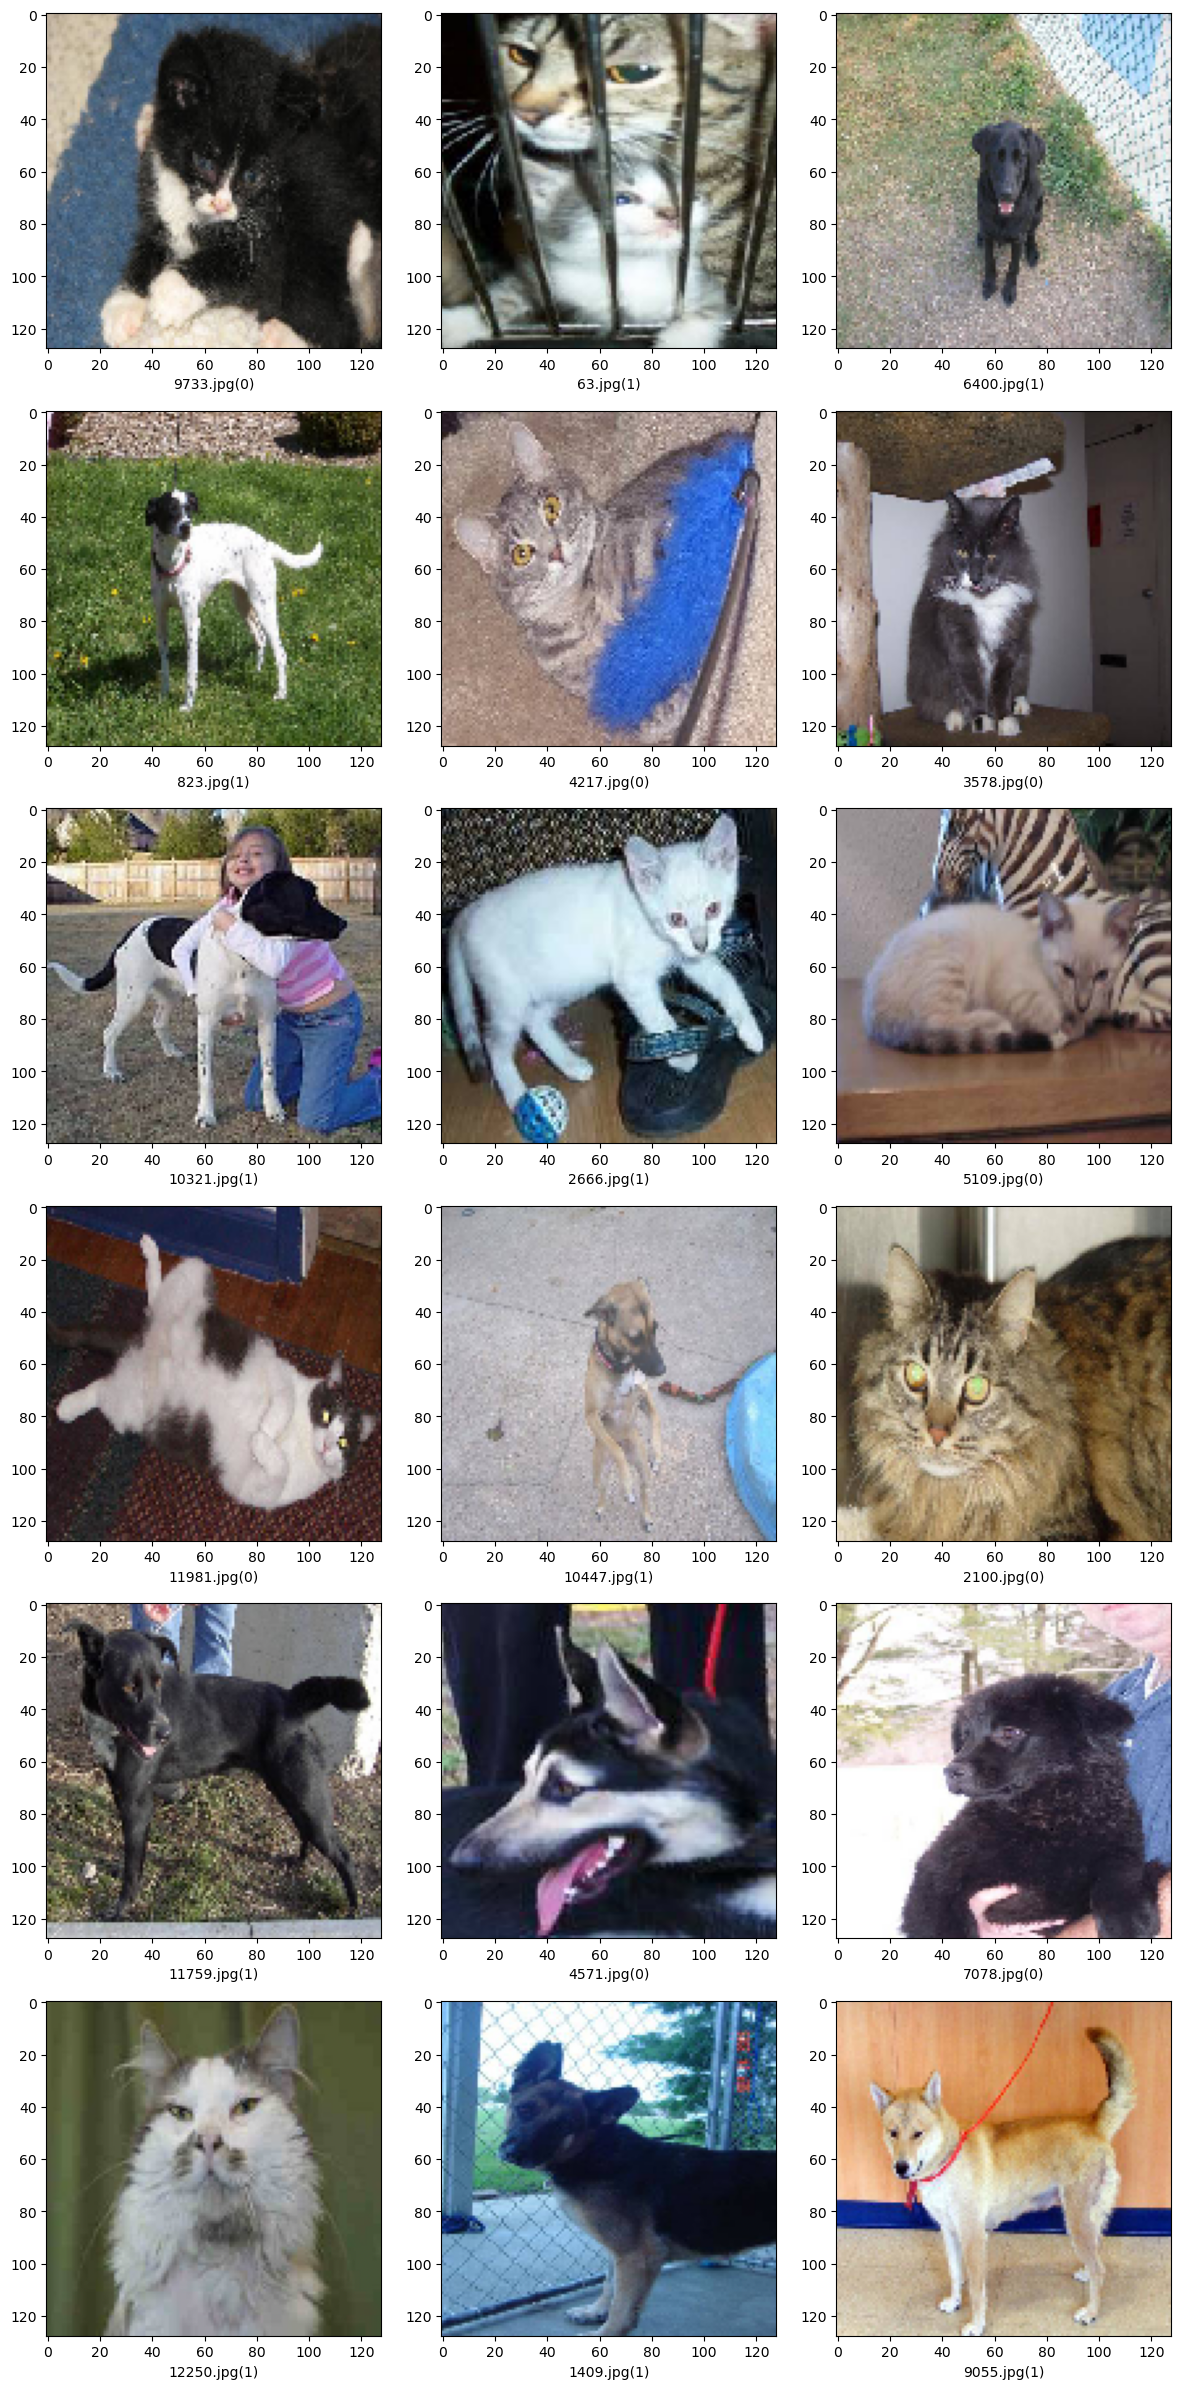

In [73]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("Cats_Dogs/test/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

> My Observation and comments on this examples : 
* Adjusting the correct and incorrect items will improve the accuracy of the predictions display.
* The display should present the predicted values alongside the actual values for a more direct interpretation, rather than just the name or label, which lacks meaningful context.
* It appears that the model may benefit from additional epochs to achieve higher performance, and we should consider trying 50 epochs. I just used 10 here for the seek of time. 

nbsp;

<a name="other_apps"></a>
## Further TensorFlow (Keras) Applications for CNN 
---------
* [The basic tools of Keras for CNN](https://github.com/momarzouksobeh/MachineLearning_for_DrugDesign_Roadmap/blob/main/1_ML_Toolkit/keras/2_Keras_BasicTools_CNN.ipynb)

* [Example No 1](https://github.com/momarzouksobeh/MachineLearning_for_DrugDesign_Roadmap/blob/main/1_ML_Toolkit/keras/CNN_case_studies/Example_No_1_images_6categories.ipynb) : 6 Categories Images Classification.

* [Example No 2](https://github.com/momarzouksobeh/MachineLearning_for_DrugDesign_Roadmap/blob/main/1_ML_Toolkit/keras/CNN_case_studies/Example_No_2_mnist_dataset_acc99.ipynb) : MNIST dataset (Acc 0.997).

* [Example No 3](https://github.com/momarzouksobeh/MachineLearning_for_DrugDesign_Roadmap/blob/main/1_ML_Toolkit/keras/CNN_case_studies/Example_No_3_fashion_related_dataset.ipynb) : fashion-related dataset. 

* [Example No 5](https://github.com/momarzouksobeh/MachineLearning_for_DrugDesign_Roadmap/blob/main/1_ML_Toolkit/keras/CNN_case_studies/Example_No_5_Cats_Dogs_classifer.ipynb) : Cats & Dogs classifier and compare to the DNN model. 

&nbsp;
<a name="resources"></a>
## Key Resources Utilized in Crafting This Notebook :
--------------------------
- <a rel="keras_website" href="https://keras.io"> Keras Official Website. </a>
- <a rel="the code used" href="https://www.youtube.com/watch?v=ohyn_MzS_hE&list=PL6-3IRz2XF5VbuU2T0gS_mFhCpKmLxvCP"> Playlist for Keras in Arabic by Hesham Asem. </a>
- <a rel="the code used2" href="https://github.com/HeshamAsem/CNN"> Hesham Asem GitHub for ML tools. </a>